## Visualizing  Spacy + Georesolver  - By Years

In this case, we have used the [SpaCy en_core_web_lg](https://spacy.io/models/en#en_core_web_lg) for finding the Name Entities of all the books of a particular edition,  and select the ones regarding with places (GPE and LOC entities). Later, once we have the locations entities, we use the [georesolver]() of the  [Edinburgh geoparser](https://programminghistorian.org/en/lessons/geoparsing-text-with-edinburgh#patch-fix) to resolve these locations.
                       
The query for running that we have used is the following: 

`sspark-submit --py-files defoe.zip defoe/run_queries.py nls_gaz.txt  nls -l query_distributed_topics.txt -n 16 `


And the queries/lang_model.yml specifies the spaCy language model to use:
`lang_model: en_core_web_lg`



### Loading the necessary libraries

In [1]:
import yaml
from IPython.core.display import display, HTML
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

### Functions

In [2]:
def read_query_results(filename):
    with open('../../../results_Gazetteer/results_with_bb/'+filename, 'r') as f:
        query_results = yaml.load(f)
    return query_results


In [3]:
def geresolution_dataframe(result):
    dfs=[]
    data=[]
    c_locs=[]    
    for i in result.keys():
        print("year %s" %i)
        t_ind = 0
        e_ind = 0
        year = i
        for k in result[i]:
            locs= k["georesolution_page"]
            page = k["text_unit id"]
            if locs != {}:
                data=[]
                l_ind = 0
                for t in locs:
                    if type(locs[t]) == type([]) :
                        c_locs=locs[t].copy()
                        c_locs.append(t.split("-")[0])
                        c_locs.append(page)
                        c_locs.append(year)
                        data.append(c_locs)
                        l_ind = l_ind + 1   
                e_ind = t_ind + l_ind 
                if data:
                    df_page = pd.DataFrame(data, columns = ['Latitude', 'Longitude', 'Place', 'Page', 'Year'], 
                                      index=list(range(t_ind, e_ind)))
                    dfs.append(df_page)
                    t_ind=e_ind
    df_total = pd.concat(dfs)
    return df_total

In [4]:
def get_place(df, lat, long):
    df_new=df.loc[(df['Latitude'] == lat) & (df['Longitude'] == long)]['Place']
    return df_new.count(), df_new.iloc[0]

In [5]:
def label_freq_places(df_total, df_max_geolocations, filter_list):
    place_label=[]
    place_freq = []
    i_limit = 15
    i =0
    k =0 
    while k < i_limit:
        place_count, place_name = get_place(df_total, df_max_geolocations.iloc[i]['Latitude'], df_max_geolocations.iloc[i]['Longitude'])
        if place_name not in filter_list:
            #print(i, place_count,place_name)
            if place_name not in place_label:
                k = k + 1
            place_label.append(place_name)
            place_freq.append(place_count)
         
        i = i + 1
    return place_label, place_freq

In [38]:
def plot_bar_places_by_years(df_group_places_years,plot_type="resolved"):
    num_subplots=len(df_group_places_years.keys())
    fig, axs = plt.subplots(num_subplots,1, squeeze=False)
    plt.subplots_adjust(hspace = 0.8, top=0.95)
    fig.set_size_inches(20, 35)
    i=0
    if plot_type == "resolved":
        fig.suptitle('15 Places most mentioned using Spacy and the Georesolver', fontsize = 20)
    else:
        fig.suptitle('15 Places most mentioned but not resolved using Spacy and the Georesolver ', fontsize = 20)
    for y in sorted(df_group_places_years.keys()):
        df_group_places = df_group_places_years[y]
        index = np.arange(len(df_group_places['Place']))

        if plot_type == "resolved":
            axs[i,0].bar(index, df_group_places['count'], color='green')
            axs[i,0].set_title('Year %s' %y, fontsize=18) 
        else: 
            axs[i,0].bar(index, df_group_places['count'], color='yellowgreen')
            axs[i,0].set_title('Year %s' %y, fontsize=18) 
        axs[i,0].set_xticks(index) 
        axs[i,0].set_xticklabels(list(df_group_places['Place']), rotation=15, fontsize=18)  
        axs[i,0].set_ylabel('Frequency of Places') 
        i=i +1 

In [7]:
# Plot lines of different places
def cumulative_plot(df, list_places, list_years):
    fig = plt.figure(figsize=(12, 6))
    line_weight = 3
    alpha = .5
    tt=df_group_places_years_final.reset_index()
    years=set()
    for pl in list_places:
        freq_term={}
        for i in sorted(list_years):
            try:
                freq_term[i]= list(tt.loc[(tt['Place']==pl) & (tt['level_0']==i) ]["count"])[0]
            except:
                freq_term[i] = 0
        plt.plot(*zip(*sorted(freq_term.items())), lw=line_weight, alpha=alpha, label=pl, marker='d') 
    
    for i in sorted(list_years):
        years.add(i)
    plt.xticks(sorted(list(years)), rotation=50)  
    plt.title('Yearly cumulative plot of selected places' )
    plt.legend(loc='upper left')
    plt.ylabel('Frequency of Places')
    plt.xlabel("Years")
    plt.show()

### Information about the defoe geoparser query

This query does the following tasks:

- Ingests all the pages from each directory listed in nls_gaz.txt, which each corresponds to a book of the "Scottish Gazzeters"
- Cleans the text applied two fixes: Long-s and hyphen words
- Identifies *entities* using the original SpaCy en_core_web_lg model.
- From the previous entities, just selects the one about *location* and creates an xml (in memory) per page with these "location" entities. 
- Applies the georesolve of the Edinburgh geoparser to each xml and gets lat and long. **Important: Everything is in memory, we do not create XML files in those steps**
- Group the results by year, and also gets some informative metadata


As a result we get a file per book with an entry per page with the following information:

    * edition: Edition of the gazetteer
    * georesolution_page: Page's geolocations after applying the georesolver
    * page_filename: Page's filename (page's relative path)
    * text_unit id: The number of this page (e.g. Page 1)
    * lang_model : The language model applied (en_core_web_lg)
    * year: Publication year 

`Example:
     
    - edition: '1828'
      georesolution_page:
       Aberdeen-rb19:
        - '57.1333333'
        - '-2.1'
       Edinburgh-rb7:
        - '55.9497284685701'
        - '-3.19333076477051'
    
      lang_model: en_core_web_lg
      page_filename: alto/97351031.34.xml
      text_unit id: Page27
      title: Descriptive account of the principal towns in Scotland to accompany Wood's town atlas`


### Reading the file and creating the first dataframe

In [8]:
results=read_query_results('georesolution_en_core_web_lg_total')

In [9]:
df_total= geresolution_dataframe(results)

year 1838
year 1848
year 1901
year 1846
year 1883
year 1803
year 1842
year 1868
year 1825
year 1882
year 1828
year 1806


In [10]:
df_total.head(15)

,Latitude,Longitude,Place,Page,Year
0,51.5879,-0.1063,LONDON,Page9,1838
1,55.95,-3.2,EDINBURGH,Page9,1838
2,55.95,-3.3725,EDINBURGH,Page9,1838
3,55.8666667,-4.25,GLASGOW,Page9,1838
4,38.8873341,-77.05553279999999,SCOTLAND,Page9,1838
5,40.2593,-75.0868,WARWICK SQUARE,Page9,1838
6,44.983403772,-79.94966107800001,Firth,Page11,1838
7,,,the Firth of Forth,Page11,1838
8,36.933119,-94.0946568,Berwick,Page11,1838
9,,,the Kershope Water,Page11,1838


### Generic Explorations 

**Important: Number of Places that has been identified!**

In [11]:
df_total[["Place"]].count()

Place    320629
dtype: int64

### Explorations with georesolved places

**Important: Going to remove City of | Contry of | County of  in the strings of Places**

In [12]:
df_total['Place'] = df_total['Place'].str.replace(r'City of ', '')
df_total['Place'] = df_total['Place'].str.replace(r'city of ', '')

In [13]:
df_total['Place'] = df_total['Place'].str.replace(r'Country of ', '')
df_total['Place'] = df_total['Place'].str.replace(r'country of ', '')

In [14]:
df_total['Place'] = df_total['Place'].str.replace(r'County of ', '')
df_total['Place'] = df_total['Place'].str.replace(r'county of ', '')

In [15]:
df_total['Place'] = df_total['Place'].str.replace(r'the ', '')
df_total['Place'] = df_total['Place'].str.replace(r'The ', '')

**Important: Number of Places that has been identified but not resolved!**

In [16]:
df_total.loc[df_total['Latitude'] == ''].count()

Latitude     36650
Longitude    36650
Place        36650
Page         36650
Year         36650
dtype: int64

**Important: Number of Places that has been identified AND  resolved!**

In [17]:
df_total.loc[df_total['Latitude'] != ''].count()

Latitude     283979
Longitude    283979
Place        283979
Page         283979
Year         283979
dtype: int64

**Important: New dataframe- df_resolved- without the rows has been resolved!!**

In [18]:
df_resolved = df_total[df_total['Latitude'] != '']

In [19]:
df_resolved.count()

Latitude     283979
Longitude    283979
Place        283979
Page         283979
Year         283979
dtype: int64

**Places names - forcing all to lower case, and later capitalize them**

In [20]:
df2 = df_resolved.copy()
df2['Place']=df_resolved['Place'].apply(str.lower)

In [21]:
df_capitalized= df2.copy()
df_capitalized['Place']=df2['Place'].apply(str.capitalize)
#displaying the first 15 rows
df_capitalized.head(15)

,Latitude,Longitude,Place,Page,Year
0,51.5879,-0.1063,London,Page9,1838
1,55.95,-3.2,Edinburgh,Page9,1838
2,55.95,-3.3725,Edinburgh,Page9,1838
3,55.8666667,-4.25,Glasgow,Page9,1838
4,38.8873341,-77.05553279999999,Scotland,Page9,1838
5,40.2593,-75.0868,Warwick square,Page9,1838
6,44.983403772,-79.94966107800001,Firth,Page11,1838
8,36.933119,-94.0946568,Berwick,Page11,1838
10,56.39153,-3.43951,Scotland,Page11,1838
11,55.65,-2.3333333,Birgham,Page11,1838


**Important: Calculating the number of georesolved places by year**

Here is when I realised that we had empty geolocations for some editions. 

In [22]:
df_capitalized.groupby("Year")["Place"].count()

Year
1803     6638
1806     6561
1825     4380
1828     1223
1838    14383
1842    30196
1846    29334
1848    15035
1868    47170
1882    22593
1883    46454
1901    60012
Name: Place, dtype: int64

### Visualizing the 15 places more mentioned (and resolved) per year

In [23]:
mpl.rcParams['figure.dpi']=300
years_list = df_capitalized['Year'].unique()
filter_list=[]
df_group_places_years={}
for y in years_list:
    df_filter_year=df_capitalized.loc[df_capitalized['Year'] == y]
    df_max_geolocations = df_filter_year[['Latitude','Longitude','Year']].groupby(['Latitude', 'Longitude','Year'])['Longitude'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)
    filter_list=['Ii', 'Mid,', 'West', 'West coast', 'Harbour']
    place_label, place_freq = label_freq_places(df_filter_year, df_max_geolocations, filter_list)
    df_places = {'Place':place_label,'Place_freq':place_freq}
    df_places_freq = pd.DataFrame(df_places)
    df_group_places = df_places_freq.groupby(['Place'])['Place_freq'].sum()\
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)   
    df_group_places_years[y]=df_group_places

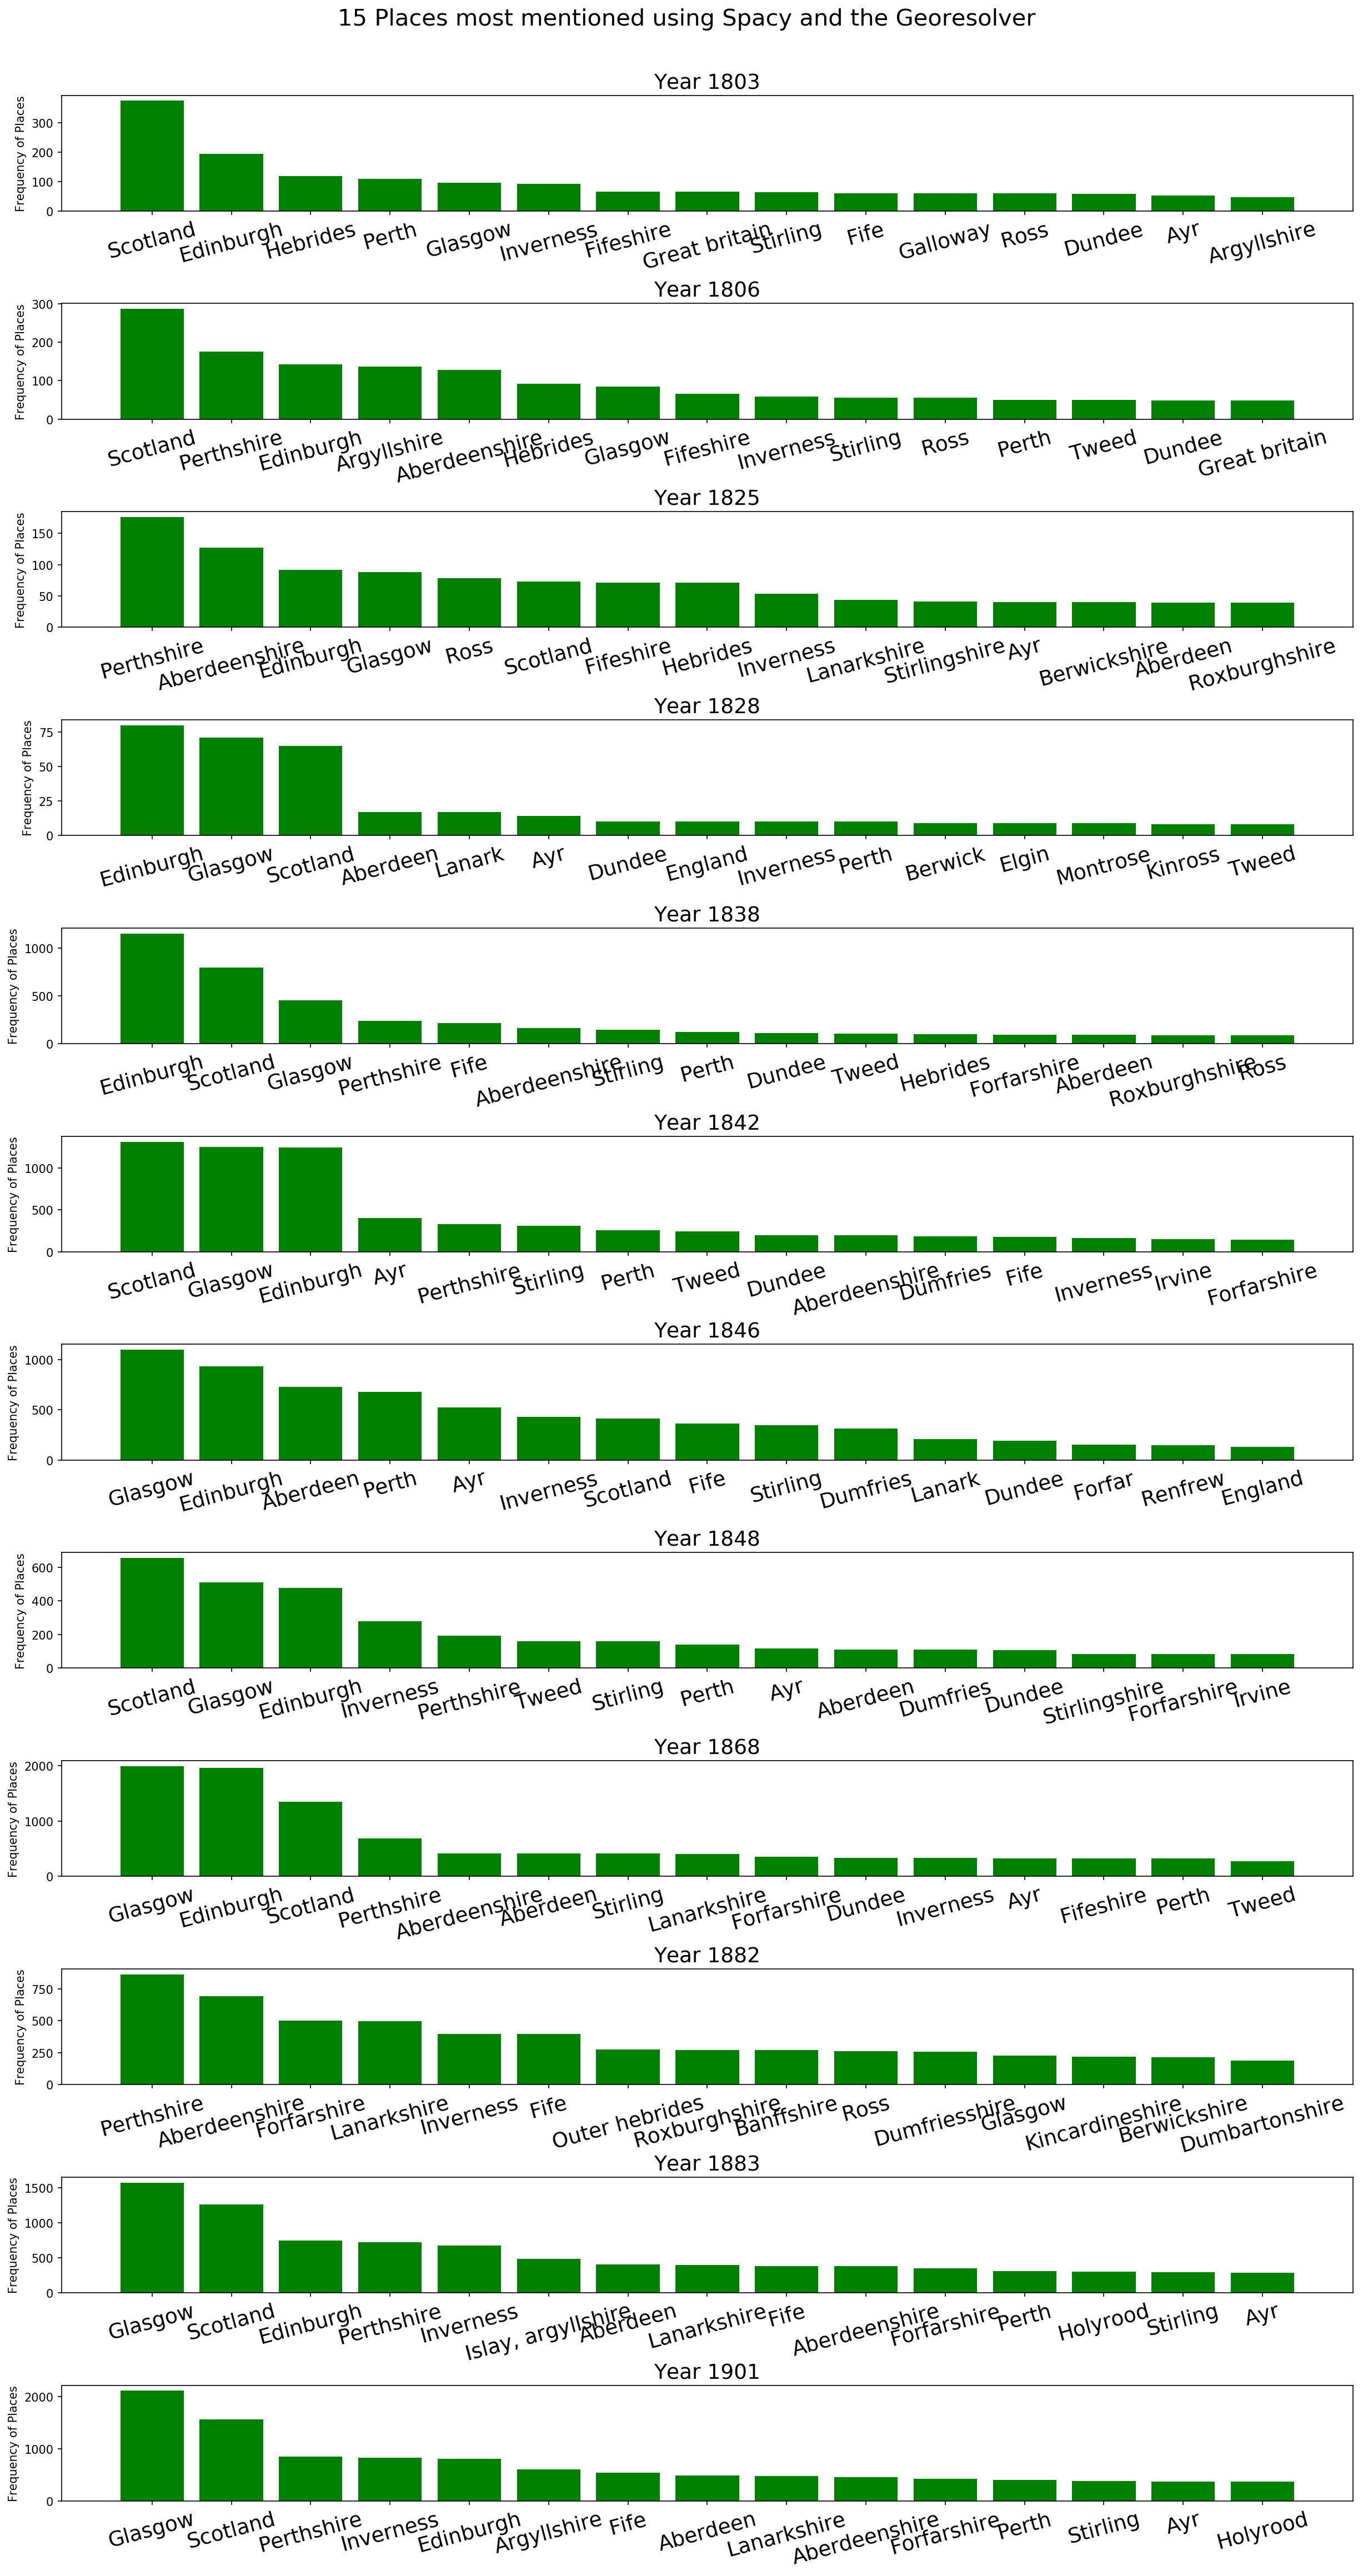

In [39]:
plot_bar_places_by_years(df_group_places_years,plot_type="resolved")

In [25]:
# Exploring the 15 places more georeolved for a particular year - e.g1828. 
df_group_places_years["1828"]

,Place,count
4,Edinburgh,80
7,Glasgow,71
13,Scotland,65
0,Aberdeen,17
10,Lanark,17
1,Ayr,14
3,Dundee,10
6,England,10
8,Inverness,10
12,Perth,10


### Cumulative Yearly Plot 

First we have to create a new concatenated dataframe with all the information per year - Years as the index 

In [26]:
df_group_places_years_final = pd.concat(df_group_places_years)

In [27]:
df_group_places_years_final.head(15)

Place  count
1803 13       Scotland    375
     3       Edinburgh    194
     9        Hebrides    118
     11          Perth    109
     7         Glasgow     96
     10      Inverness     93
     5       Fifeshire     65
     8   Great britain     65
     14       Stirling     63
     4            Fife     60
     6        Galloway     60
     12           Ross     60
     2          Dundee     58
     1             Ayr     52
     0     Argyllshire     46

Just an example how to explore the number of times that Edinburgh has been georesolved over the years

In [28]:
df_group_places_years_final.loc[df_group_places_years_final['Place']=='Edinburgh']


,,Place,count
1803,3,Edinburgh,194
1806,3,Edinburgh,142
1825,4,Edinburgh,92
1828,4,Edinburgh,80
1838,3,Edinburgh,1150
1842,4,Edinburgh,1243
1846,4,Edinburgh,932
1848,4,Edinburgh,478
1868,4,Edinburgh,1954
1883,3,Edinburgh,747


In [29]:
df_group_places_years_final.Place.unique()

array(['Scotland', 'Edinburgh', 'Hebrides', 'Perth', 'Glasgow',
       'Inverness', 'Fifeshire', 'Great britain', 'Stirling', 'Fife',
       'Galloway', 'Ross', 'Dundee', 'Ayr', 'Argyllshire', 'Perthshire',
       'Aberdeenshire', 'Tweed', 'Lanarkshire', 'Stirlingshire',
       'Berwickshire', 'Aberdeen', 'Roxburghshire', 'Lanark', 'England',
       'Berwick', 'Elgin', 'Montrose', 'Kinross', 'Forfarshire',
       'Dumfries', 'Irvine', 'Forfar', 'Renfrew', 'Outer hebrides',
       'Banffshire', 'Dumfriesshire', 'Kincardineshire', 'Dumbartonshire',
       'Islay, argyllshire', 'Holyrood'], dtype=object)

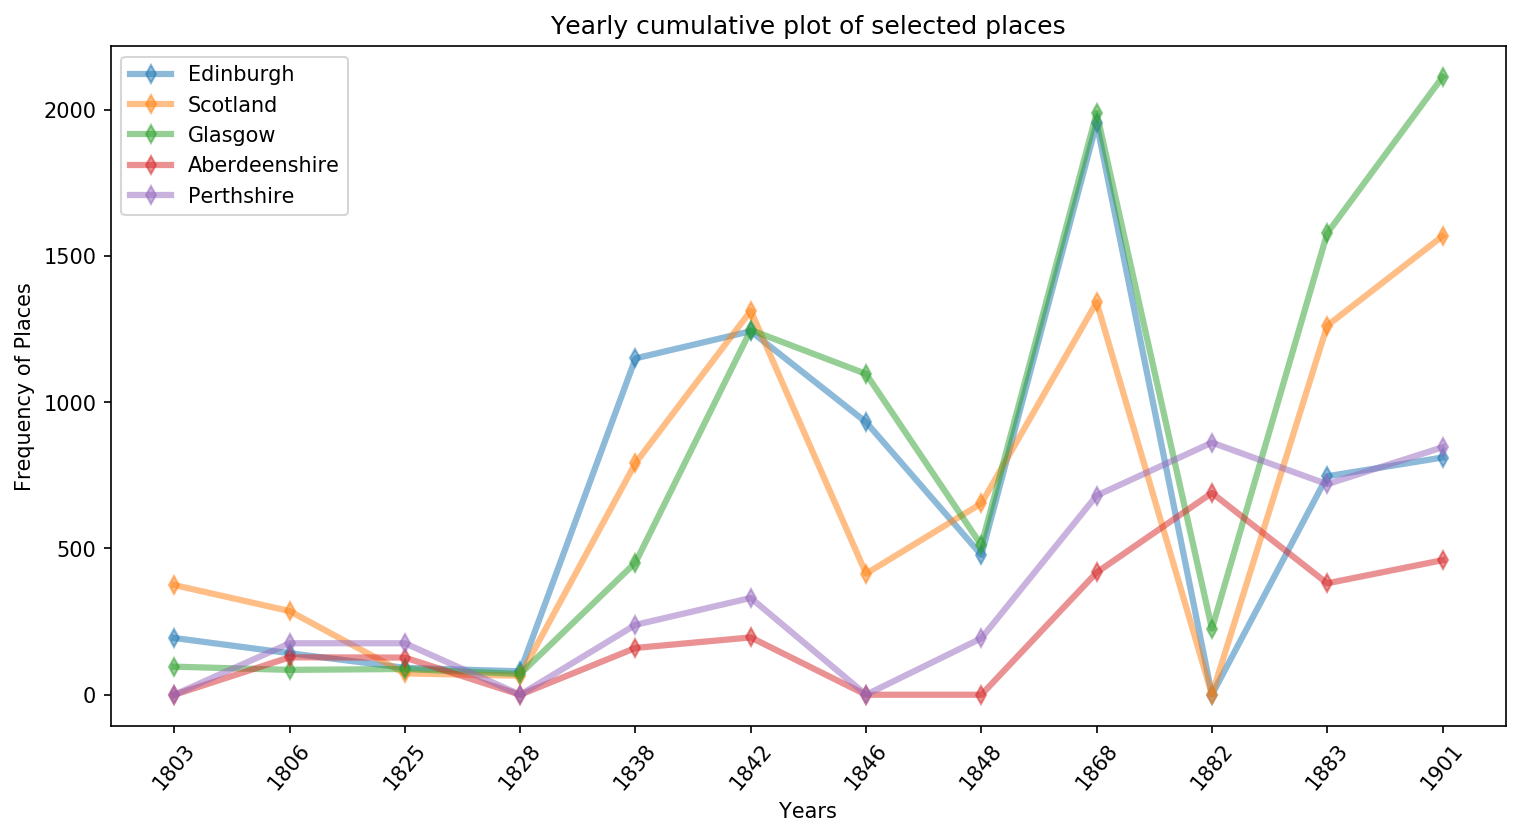

In [30]:
#df_group_places_years_final.loc[df_group_places_years_final['Place']=='Edinburgh']
mpl.rcParams['figure.dpi']=150
list_places=["Edinburgh", "Scotland", "Glasgow", "Aberdeenshire", "Perthshire"]
cumulative_plot(df_group_places_years, list_places, sorted(years_list))